# Prompt

First, you learned about the importance of transforming your data into a stationary series. You tested for stationarity using the adfuller function and interpreted the value of the hypothesis test. If the data was not stationary, you learned how to apply strategies, such as differencing and logarithmic transformations, to achieve stationarity.

Once the series was stationary, building an ARMA model involved using autocorrelation and partial autocorrelation plots to determine the appropriate p and q parameters of the model.

This activity asks you to identify a time series of interest to you and build an ARMA model to construct a basic forecast for the series and analyze the error. You might also consider building models with different p and q parameters because, while ACF and PACF plots are helpful, they provide rough ideas of the appropriate parameters, and it is usually good practice to perform a simple grid search on these. 

Please find a time series dataset using any resource you would like, and present your model and findings to the class.  

If you have trouble locating a dataset or would prefer a suggestion, try the [Rossmann Store Sales](https://www.kaggle.com/c/rossmann-store-sales) from Kaggle. This dataset involves forecasting retail store sales for a major drug store.

# Imports

In [1]:
import warnings
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose, _extrapolate_trend
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

# Data Load

Looking at snowfall per month for Mammoth Mountain, from 1969 to the present, as obtained from  
- https://www.mammothmountain.com/on-the-mountain/snowfall-history

See [pre-processing notebook](./mammoth_snowfall_datagen.ipynb) for how I generated this table from the Mammoth website data

In [3]:
df = pd.read_csv("./data/mammoth_mountain_snowfall.csv")
df.head()

,Unnamed: 0,Season,Total,Pre-Oct,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul
0,0,2023-24,354.0,0,0.0,14.0,12.0,72.0,133.0,95.0,28.0,NaN,NaN,NaN
1,1,2022-23,715.0,0,0.0,61.0,116.0,220.0,113.0,192.0,3.0,10.0,0.0,0.0
2,2,2021-22,260.0,0,32.0,9.0,161.0,0.0,7.0,14.0,34.0,3.0,0.0,0.0
3,3,2020-21,244.5,0,0.0,21.0,33.0,108.5,22.0,53.0,5.0,2.0,0.0,0.0
4,4,2019-20,281.0,0,0.0,54.0,71.0,13.0,0.0,83.0,57.0,3.0,0.0,0.0


In [4]:
df["Season"] = df["Season"].apply(lambda x: int(x.split("-")[0]))
df.drop(columns=["Unnamed: 0"], inplace=True)
df.rename(columns={"Season": "Year"}, inplace=True)
df.head()

,Year,Total,Pre-Oct,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul
0,2023,354.0,0,0.0,14.0,12.0,72.0,133.0,95.0,28.0,NaN,NaN,NaN
1,2022,715.0,0,0.0,61.0,116.0,220.0,113.0,192.0,3.0,10.0,0.0,0.0
2,2021,260.0,0,32.0,9.0,161.0,0.0,7.0,14.0,34.0,3.0,0.0,0.0
3,2020,244.5,0,0.0,21.0,33.0,108.5,22.0,53.0,5.0,2.0,0.0,0.0
4,2019,281.0,0,0.0,54.0,71.0,13.0,0.0,83.0,57.0,3.0,0.0,0.0


In [5]:
df["Max in a Month"] = df[df.columns[2:]].max(axis=1)

In [6]:
df.head()

,Year,Total,Pre-Oct,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Max in a Month
0,2023,354.0,0,0.0,14.0,12.0,72.0,133.0,95.0,28.0,NaN,NaN,NaN,133.0
1,2022,715.0,0,0.0,61.0,116.0,220.0,113.0,192.0,3.0,10.0,0.0,0.0,220.0
2,2021,260.0,0,32.0,9.0,161.0,0.0,7.0,14.0,34.0,3.0,0.0,0.0,161.0
3,2020,244.5,0,0.0,21.0,33.0,108.5,22.0,53.0,5.0,2.0,0.0,0.0,108.5
4,2019,281.0,0,0.0,54.0,71.0,13.0,0.0,83.0,57.0,3.0,0.0,0.0,83.0


In [7]:
df = df[::-1]
df.head()

,Year,Total,Pre-Oct,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Max in a Month
54,1969,244.5,22,0.0,0.0,41.0,78.0,30.5,46.0,27.0,0.0,0.0,0.0,78.0
53,1970,255.5,60,0.0,0.0,109.0,29.0,19.5,24.0,14.0,0.0,0.0,0.0,109.0
52,1971,268.5,22,0.0,9.0,139.8,32.2,11.0,1.0,53.5,0.0,0.0,0.0,139.8
51,1972,370.5,4,0.0,57.1,64.5,84.9,103.0,43.0,10.0,4.0,0.0,0.0,103.0
50,1973,306.5,45,0.0,0.0,45.0,87.5,9.0,82.0,38.0,0.0,0.0,0.0,87.5


In [8]:
df["Year"] = pd.to_datetime(df["Year"], format="%Y")
df = df.set_index("Year")
df.head()

,Total,Pre-Oct,Oct,Nov,Dec,Jan,Feb,Mar,Apr,May,Jun,Jul,Max in a Month
Year,,,,,,,,,,,,,
1969-01-01,244.5,22,0.0,0.0,41.0,78.0,30.5,46.0,27.0,0.0,0.0,0.0,78.0
1970-01-01,255.5,60,0.0,0.0,109.0,29.0,19.5,24.0,14.0,0.0,0.0,0.0,109.0
1971-01-01,268.5,22,0.0,9.0,139.8,32.2,11.0,1.0,53.5,0.0,0.0,0.0,139.8
1972-01-01,370.5,4,0.0,57.1,64.5,84.9,103.0,43.0,10.0,4.0,0.0,0.0,103.0
1973-01-01,306.5,45,0.0,0.0,45.0,87.5,9.0,82.0,38.0,0.0,0.0,0.0,87.5


# All Data

## Plot

In [9]:
y = df["Total"]
y = df["Max in a Month"]

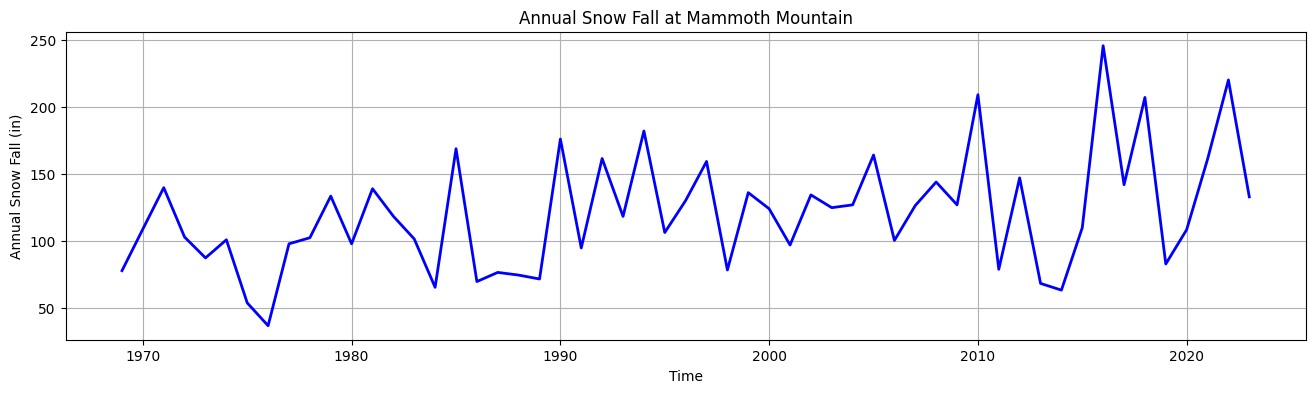

In [10]:
plt.figure(figsize=(16, 4))
plt.plot(y, color="blue", lw=2)
plt.title("Annual Snow Fall at Mammoth Mountain")
plt.xlabel("Time")
plt.ylabel("Annual Snow Fall (in)")
plt.show()

## Stationary! - Use AR(p=1) and MA(q=1)

AR(p)
- PACF
- p = 4  

MA(q)
- ACF
- q = 1  

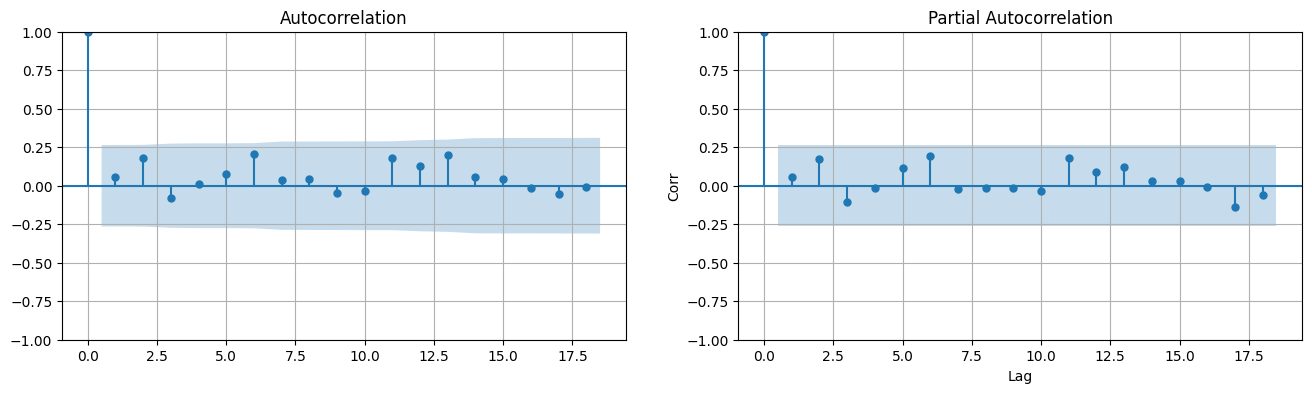

In [11]:
(fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
plot_acf(y, ax=ax[0])
plt.xlabel("Lag")
plt.ylabel("Corr")
plot_pacf(y, ax=ax[1])
plt.xlabel("Lag")
plt.ylabel("Corr")
plt.show()

In [12]:
display(adfuller(y))

(-6.8555423102999065,
 1.6520994644829603e-09,
 0,
 54,
 {'1%': -3.55770911573439,
  '5%': -2.9167703434435808,
  '10%': -2.59622219478738},
 451.0803519309842)

# Train / Test Split on y_diff2

In [13]:
n_test = 3
y_history = y[: len(y) - n_test]
y_future = y[len(y) - n_test :]

# Fit with ARIMA

In [14]:
ss_list = range(1, 3)
ss_list

range(1, 3)

In [15]:
p_list = range(1, 5)
q_list = range(1, 5)
d_list = range(1, 3)
mae_fit_list = []
rmse_fit_list = []
best = np.Inf

sp_list = range(1, 3)
sq_list = range(1, 3)
sd_list = range(1, 3)
ss_list = range(2, 4)

for p in p_list:
    for q in q_list:
        for d in d_list:
            order_p_d_q = (p, d, q)
            for sp in sp_list:
                for sq in sq_list:
                    for sd in sd_list:
                        for ss in ss_list:
                            seasonal_order_p_d_q_s = (sp, sd, sq, ss)
                            try:
                                estimator = SARIMAX(
                                    y_history,
                                    order=order_p_d_q,
                                    seasonal_order=seasonal_order_p_d_q_s,
                                ).fit()
                            except:
                                continue

                            y_fit = estimator.predict()
                            mae_fit = mean_absolute_error(y_history, y_fit)
                            rmse_fit = root_mean_squared_error(y_history, y_fit)
                            if rmse_fit < best:
                                best = rmse_fit
                                print(
                                    "P = %d, D = %d, Q = %d, SP = %d, SD = %d, SQ = %d, SS = %d, MAE = %.2f, RMSE = %.2f"
                                    % (p, d, q, sp, sd, sq, ss, mae_fit, rmse_fit)
                                )

P = 4, D = 1, Q = 3, MAE = 30.51, RMSE = 39.17

In [16]:
order_p_d_q = (1, 1, 1)
seasonal_order_p_d_q_s = (2, 1, 1, 2)
estimator = ARIMA(y_history, order=order_p_d_q, seasonal_order=seasonal_order_p_d_q_s).fit()
y_fit = estimator.predict()
y_forecast = estimator.forecast(steps=len(y_future))

In [17]:
mae_fit = mean_absolute_error(y_history, y_fit)
rmse_fit = root_mean_squared_error(y_history, y_fit)
mae_forecast = mean_absolute_error(y_future, y_forecast)
rmse_forecast = root_mean_squared_error(y_future, y_forecast)
[mae_fit, rmse_fit, mae_forecast, rmse_forecast]

[35.10743885043974, 43.7326781349391, 44.58949974233621, 55.730018289434724]

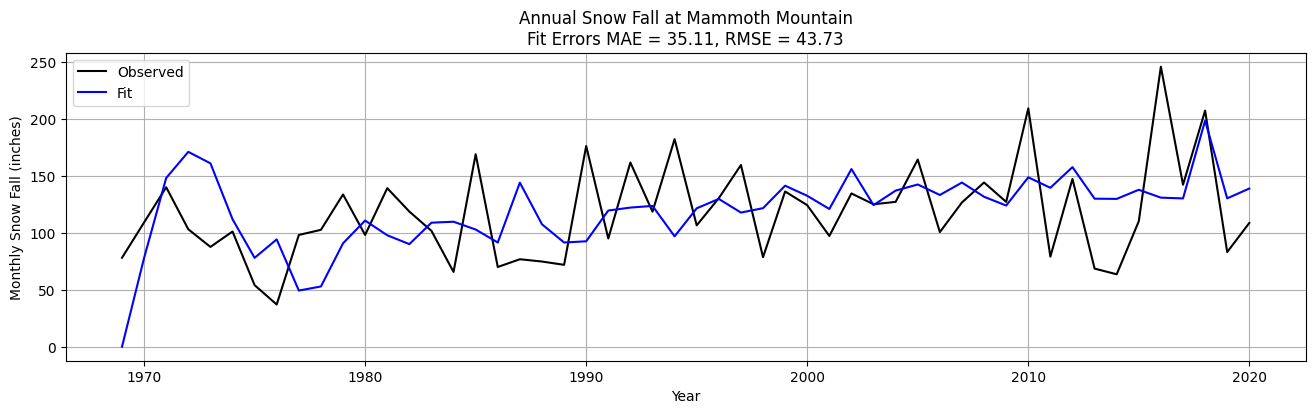

In [18]:
plt.figure(figsize=(16, 4))
plt.plot(y_history, color="black", label="Observed")
plt.plot(
    y_fit,
    color="blue",
    label="Fit",
)
plt.title(
    "Annual Snow Fall at Mammoth Mountain\nFit Errors MAE = %.2f, RMSE = %.2f"
    % (mae_fit, rmse_fit)
)
plt.xlabel("Year")
plt.ylabel("Monthly Snow Fall (inches)")
plt.legend(loc="upper left")
plt.show()

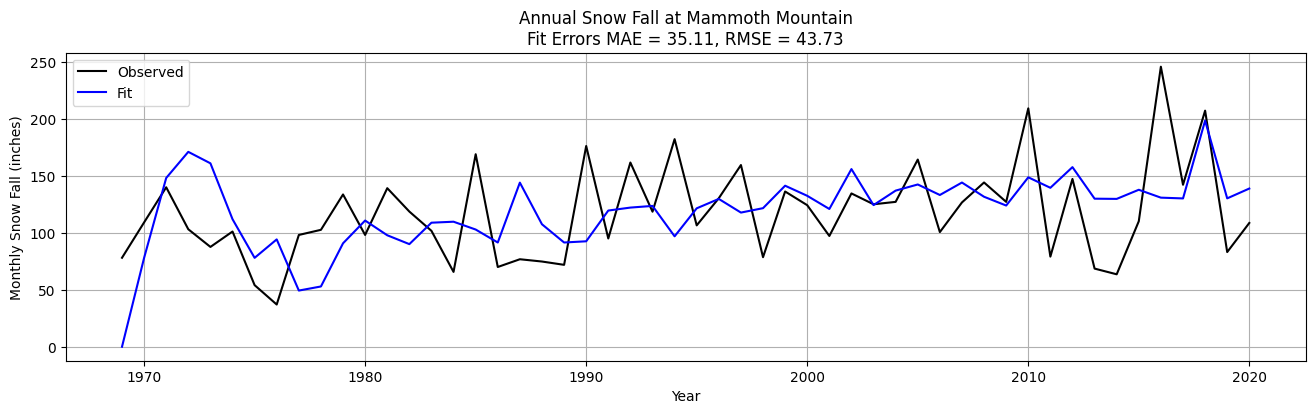

## Plot Residue

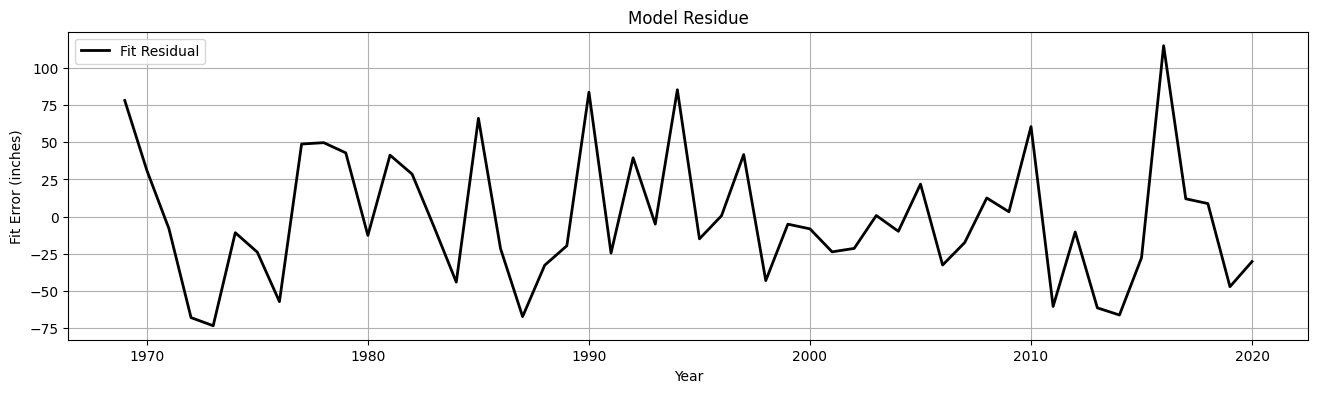

In [19]:
plt.figure(figsize=(16, 4))
plt.plot(estimator.resid, color="black", lw=2, label="Fit Residual")
plt.title("Model Residue")
plt.xlabel("Year")
plt.ylabel("Fit Error (inches)")
plt.legend(loc="upper left")
plt.show()

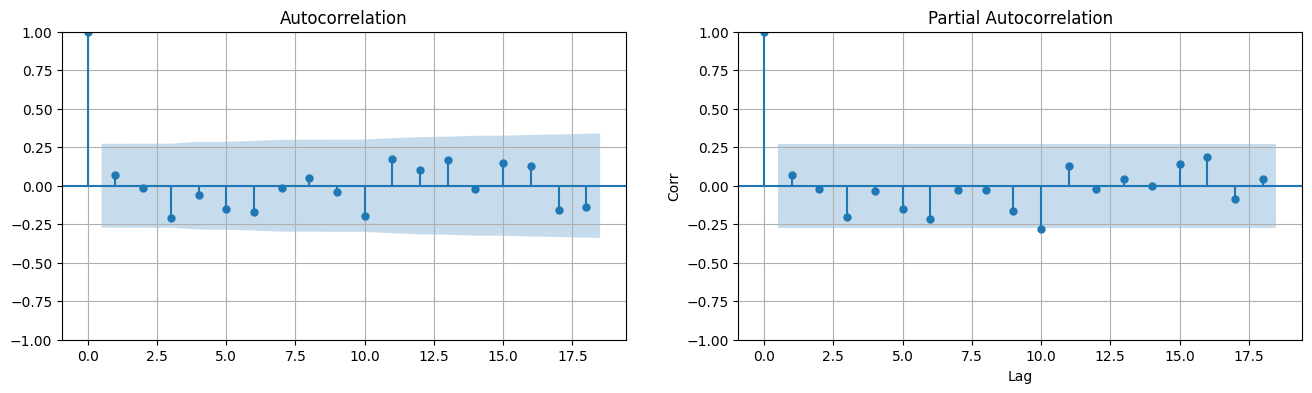

In [20]:
(fig, ax) = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
plot_acf(estimator.resid, ax=ax[0])
plt.xlabel("Lag")
plt.ylabel("Corr")
plot_pacf(estimator.resid, ax=ax[1])
plt.xlabel("Lag")
plt.ylabel("Corr")
plt.show()